 This project focuses on "Poisson blending", a technique to blend and tone-map an image into another image.

In [1]:
import numpy as np  # for building and manipulating matrices
import time  # for measuring time elapsed while running code

# for sparse matrix operations
from scipy.sparse import lil_matrix
import scipy.sparse.linalg as sla
from skimage.transform import resize

# for graphics
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
# for interactive graph features
%matplotlib notebook
%config InlineBackend.figure_format = 'retina'  # nice retina graphics

## Background
The primary goal is to seamlessly blend an object or texture from a source image into a target image. The simplest method would be to just copy and paste the pixel values from one image directly into the other. Unfortunately, this will create very noticeable seams, even if the backgrounds are well-matched. How can we get rid of these seams without doing too much perceptual damage to the source region?

![](setup.png)

The insight is that our visual system is often more sensitive to the gradient of an image (how quickly the pixel values change left-right and up-down) than the overall intensity. We will therefore set up the problem as finding values for the pasted target pixels that maximally preserve the gradient of the source region without changing any of the background pixels. Note that we are making a deliberate decision here to ignore the overall intensity! So a green hat could turn red, but it will still look like a hat.

Below is implementation of `least_squares_2D`, which takes two parameters, `im_s` and `im_background`, each of which have dimensions $(W + 2) \times (H + 2)$ (height and width of sources, respectively). The function returns the interior region (`im_blend`, dimensions $W \times H$) of `im_s` and at the same time paste `im_blend` onto the interior region of `im_background`.


In [2]:
def least_squares_2D(im_s, im_background):
    # initialize results to just be copies of the background
    im_blend = im_background.copy()
    
    # initialize the size of source image 
    imh, imw = (im_s.shape[0], im_s.shape[1])    # imh: image hight, imw: image width
    imd = 1 if im_s.ndim < 3 else im_s.shape[2]  # number of components of each pixel, e.g., for an RGB image, imd=3
    
    # specify the number of unknowns and number of equations
    num_vars = (imh - 2) * (imw - 2)
    num_eqns = (imh - 1) * (imw - 2) + (imw - 1) * (imh - 2)  
    
    # initialize the vectorization mapping

    im2var = np.zeros((imh, imw), dtype = np.int32)
    im2var[1:-1, 1:-1] = np.arange(0, (imh - 2) * (imw - 2), dtype = np.int32).reshape((imh - 2), (imw - 2))
    
    # check if the mapping is initialized correctly
    print(f"im2var:\n{im2var}")
    
    # initialize A and b
    A = lil_matrix((num_eqns, num_vars))
    b = np.zeros((num_eqns, imd))
    
    # fill the elements of A and b
      
    eq = 0 # Keep track of which equation it is in unknown matrix A

    # Add vertical constraints
    for x in range (1, imw - 1):
        # upper boundary
        A[eq, im2var[1, x]] = 1
        b[eq] = im_s[1, x] - im_s[0, x] + im_background[0, x]
        eq += 1
        
        # interior
        for y in range (2, imh - 1):
            A[eq, im2var[y, x]] = 1
            A[eq, im2var[y - 1, x]] = -1
            b[eq] = im_s[y, x] - im_s[y - 1, x]
            eq += 1
            
        # lower boundary
        A[eq, im2var[-2, x]] = -1
        b[eq] = im_s[-1, x] - im_s[-2, x] - im_background[-1, x]
        eq += 1
    
    # Add horizontal constraints
    for y in range (1, imh - 1):
        # upper boundary
        A[eq, im2var[y, 1]] = 1
        b[eq] = im_s[y, 1] - im_s[y, 0] + im_background[y, 0]
        eq += 1
        
        # interior
        for x in range (2, imw - 1):
            A[eq, im2var[y, x]] = 1
            A[eq, im2var[y, x - 1]] = -1
            b[eq] = im_s[y, x] - im_s[y, x - 1]
            eq += 1
        
        # lower boundary
        A[eq, im2var[y, -2]] = -1
        b[eq] = im_s[y, -1] - im_s[y, -2] - im_background[y, -1]
        eq += 1       
  
    # solve the least-squares problem
    
    # convert A to (CSR) sparse format
    A = A.tocsr()
    
    print('Solving sparse system using sla.lsqr...')
    t = time.time()

    # solve for all channels
    for c in range(0,imd):
        v = sla.lsqr(A, b[:,c])[0]
        
        # copy over to im_blend
        if im_s.ndim > 2: # this branch is for rgb image
            im_blend[1:-1, 1:-1, c] = v.reshape(imh - 2, imw - 2) 
            
        else:  # this branch is for gray-scale image   
            im_blend[1:-1, 1:-1] = v.reshape(imh - 2, imw - 2)
    elapsed = time.time() - t
    print("\tTotal time for sparse solve: {} seconds \n".format(elapsed))

    #### return the blended result
    return im_blend

## Poisson Blending

For Poisson Blending, select a coordinate on the background image which will serve as the bottom right corner for an object image to be blended into the background image. Ideally, the background of the object image and the surrounding area of the target region will be of similar color. 

<IPython.core.display.Javascript object>


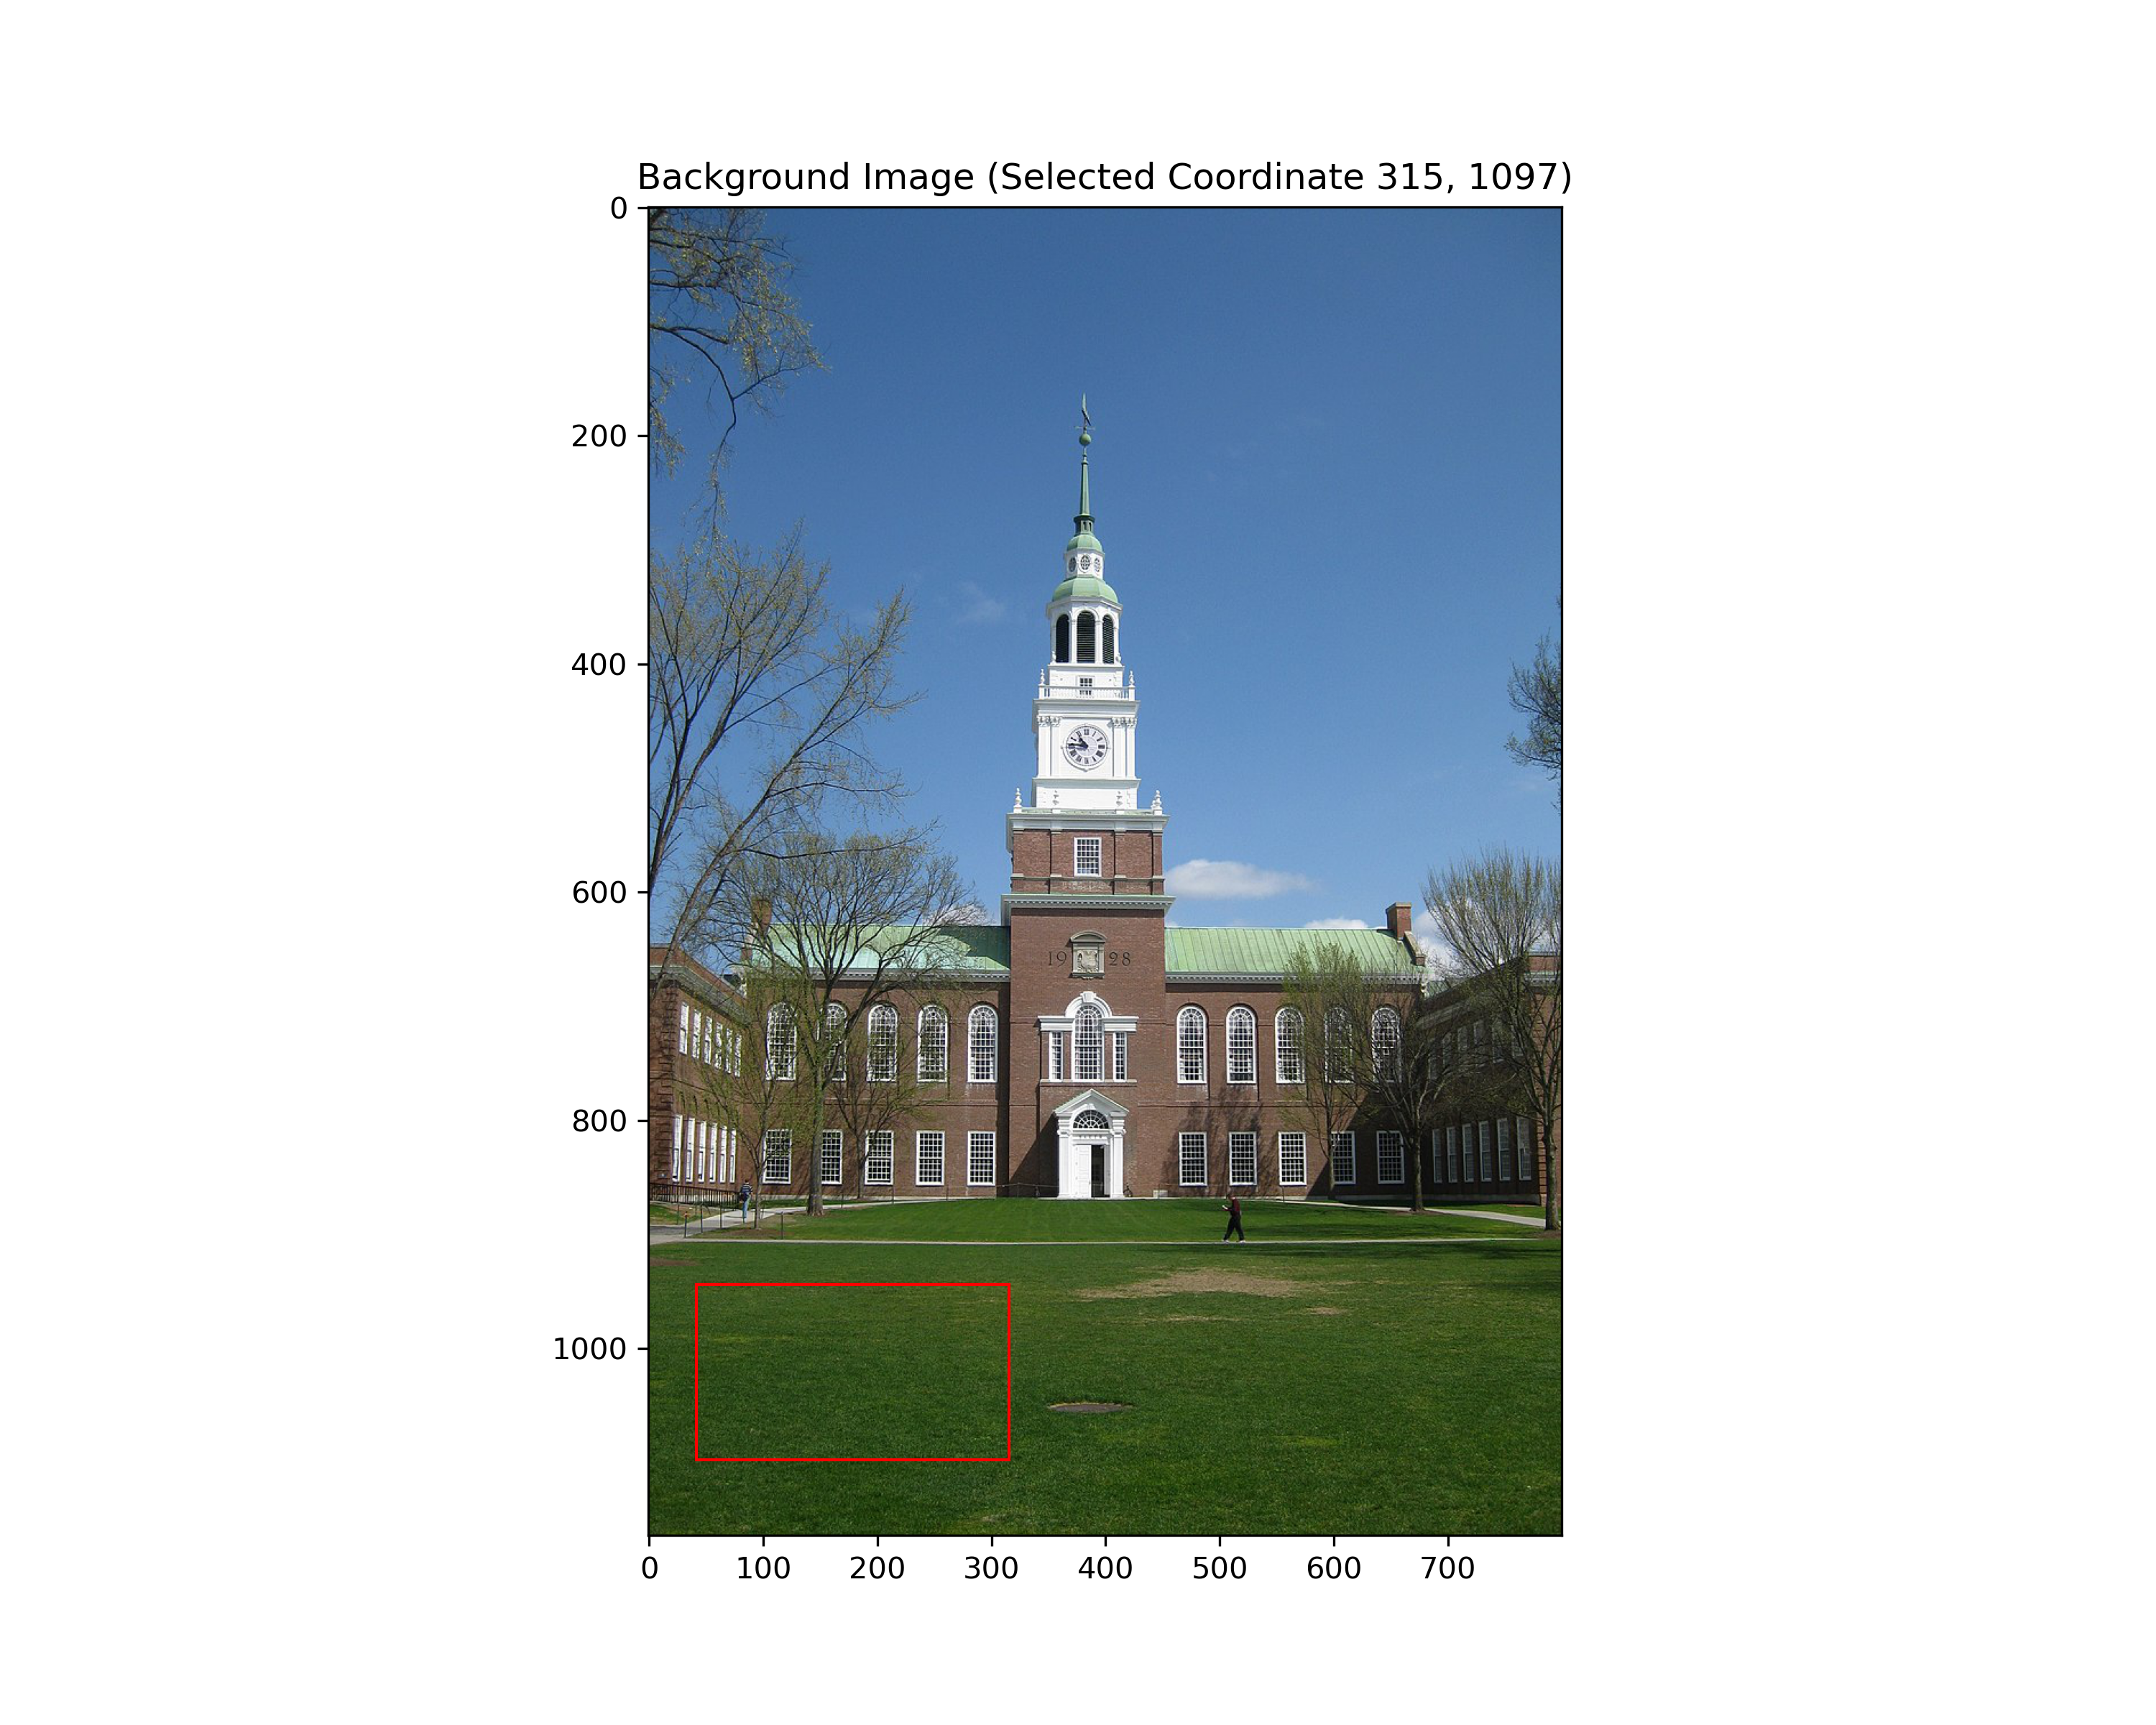

In [3]:
# Other images can be substituted in here
im_background = plt.imread('BakerLibrary.jpg')/255.0
im_object = plt.imread('messi_mbappe.jpg')/255.0
im_object = resize(im_object, (im_object.shape[0] // 7,
                               im_object.shape[1] // 7),
                      anti_aliasing=True)
# get source region mask from the user
objh, objw, _ = im_object.shape
objmask = np.ones((objh, objw))

# for storing the selected coordinates aligning blending
coords = np.zeros(2, dtype=np.int64)

# handling coordinate selection by storing selected coordinates
def onclick(event):
    global coords, objh, objw
    coords = np.round([event.xdata, event.ydata]).astype(np.int64)
    plt.title(f"Background Image (Selected Coordinate {coords[0]}, {coords[1]})")
    # draw rectangle on image
    rect = Rectangle((event.xdata-objw,event.ydata-objh),objw,objh,linewidth=1,edgecolor='r',facecolor='none')
    plt.gca().add_patch(rect)

# display interactive figure for selecting coordinate in background image
fig = plt.figure()
fig.set_size_inches(10,8)
plt.imshow(im_background)
cid = fig.canvas.mpl_connect('button_press_event', onclick) # for handling button click
plt.title("Background Image (Click a place to blend object image (Right-corner for wanted image))")
plt.show()

In [4]:
def simple_copy_paste(coords, im_object, im_background):
    x, y = coords
    objh, objw, _ = im_object.shape
    
    # paste pixel values into im_background
    result = im_background.copy()
    result[y-objh:y, x-objw:x, :] = im_object
    
    return result

def poisson_copy_paste(coords, im_object, im_background):
    x, y = coords
    objh, objw, _ = im_object.shape

    res = im_background.copy()
    background = im_background[y-objh:y, x-objw:x, :]
    
    im_blend = least_squares_2D(im_object[:,:,:], background[:,:,:])
    res[y-objh:y, x-objw:x, :] = im_blend
    
    return res

<IPython.core.display.Javascript object>


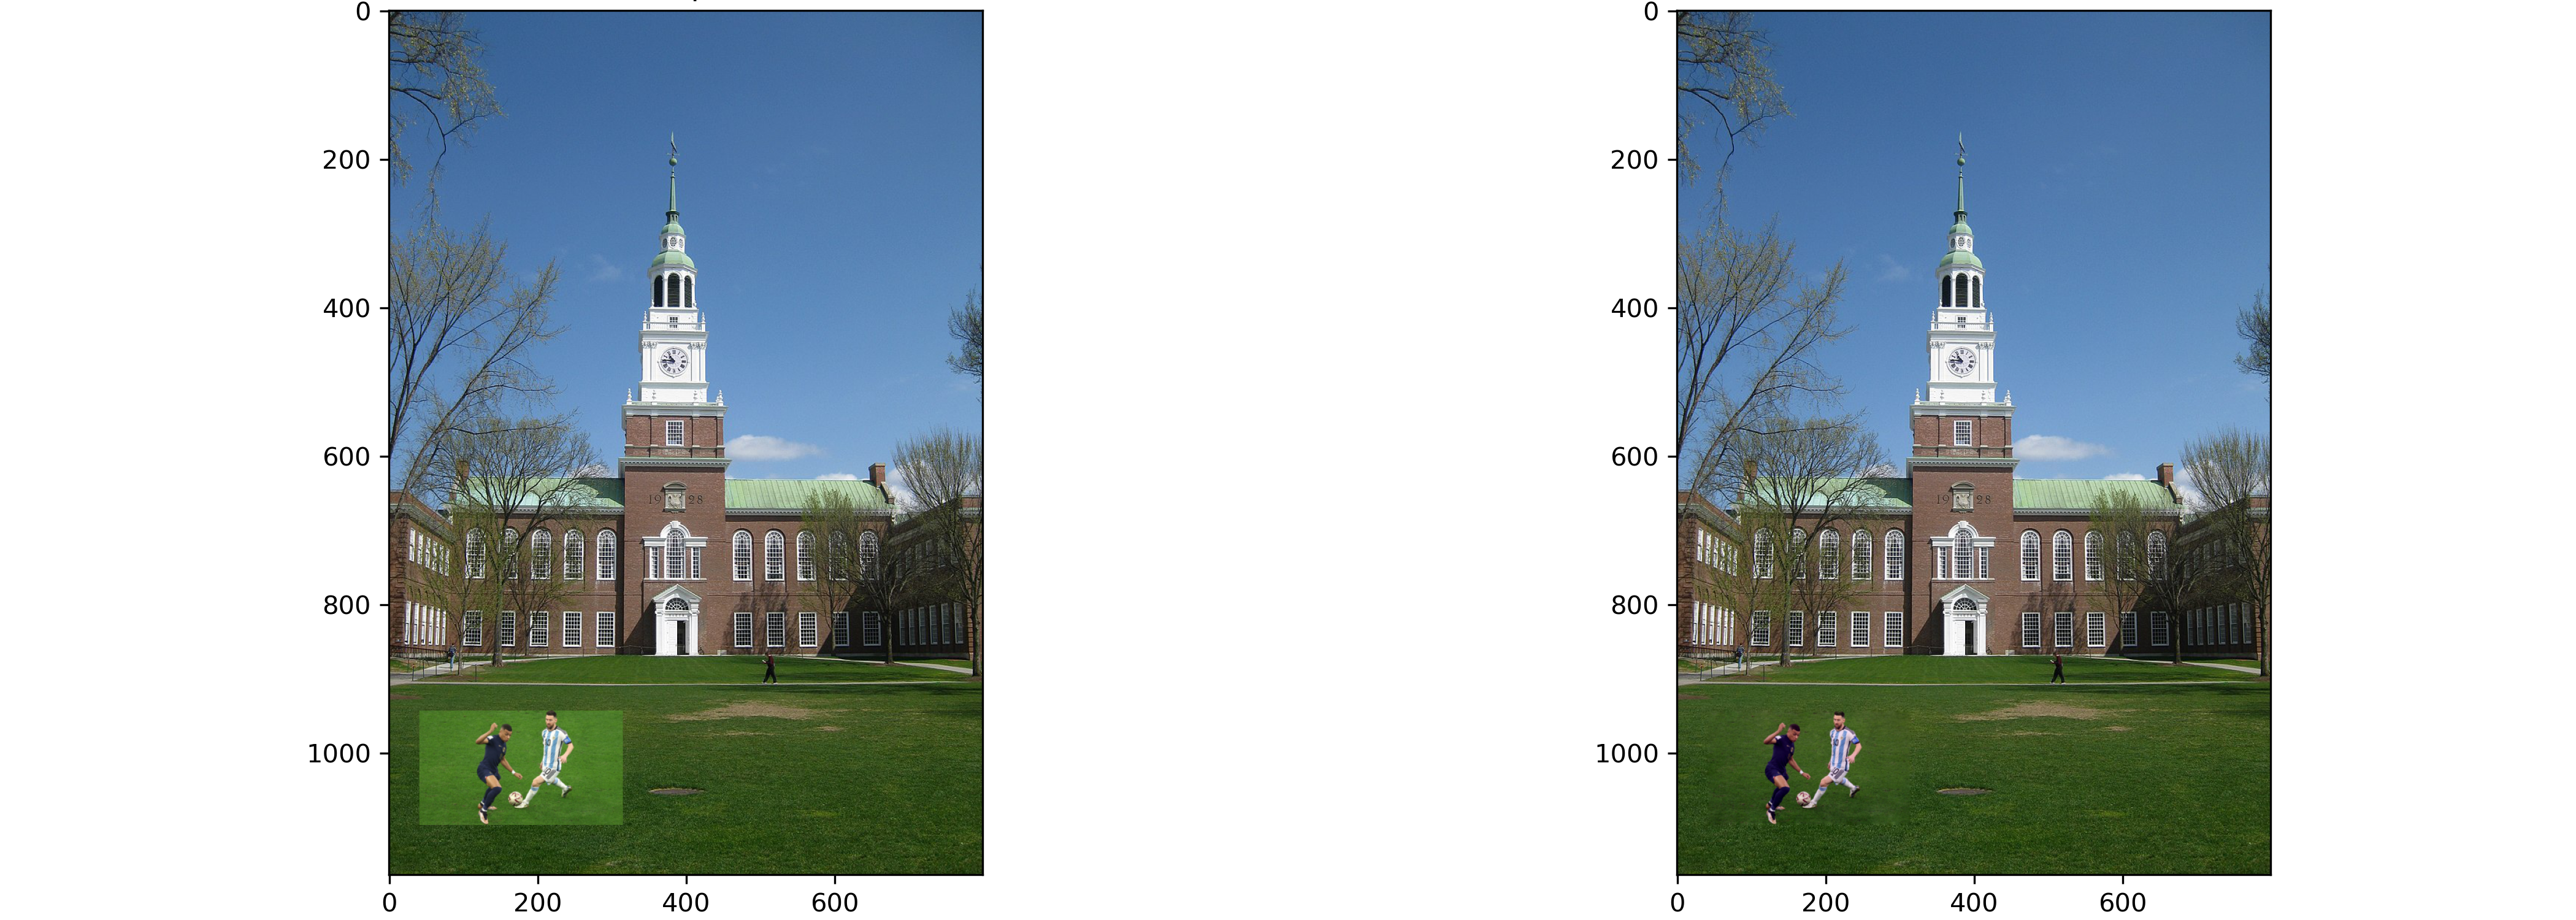

im2var:
[[    0     0     0 ...     0     0     0]
 [    0     0     1 ...   270   271     0]
 [    0   272   273 ...   542   543     0]
 ...
 [    0 40800 40801 ... 41070 41071     0]
 [    0 41072 41073 ... 41342 41343     0]
 [    0     0     0 ...     0     0     0]]
Solving sparse system using sla.lsqr...
	Total time for sparse solve: 2.5975160598754883 seconds 



In [5]:
res0 = simple_copy_paste(coords, im_object, im_background)

fig3, axs3 = plt.subplots(1,2)
fig3.tight_layout(pad=0.0)
fig3.set_size_inches(14,5)

# show simple copy-paste first
axs3[0].imshow(res0.clip(0, 1))
axs3[0].set_title("Simple")

# poisson-blending
res = poisson_copy_paste(coords, im_object, im_background)
axs3[1].imshow(res.clip(0, 1))
axs3[1].set_title("Poisson")
plt.show()

In [9]:
plt.imsave('blended.jpg', res.clip(0,1))